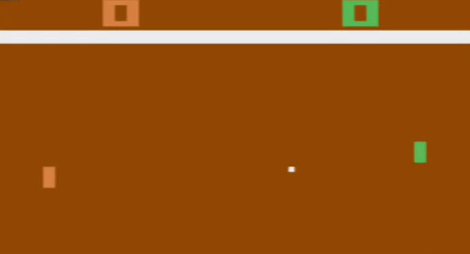

# Алгоритм Преймущественный Актёр-Критик

Преймущественный актёр-критик - это по сути доработка над алгоритмом REINFORCE, где используется преймущество для наибольшей стабильности обучения алгоритма. Общая логика алгоритма, и его код, в многом похожи на алгоритм REINFORCE.

По сколкько это алгоритмы из одного семейства, мы также воспользуемся возможностью сравнить работу этих двух алгоритмов - по этому агент будет обучаться на той же среде, PongDeterministic-V4.

В итоге, весь код создания среды и предобработки данных будет почти одинаковым, и будут всего несколько отличий. В ноутбуке будет отмечены все ячейки кода, которые сильно не поменялись из занятия по алгоритму REINFORCE. Мы советуем не обращать много внимания на такие ячейки, по скольку там ничего нового нету.

Сначала, мы загружаем все ROM-ы для библиотеки Gym.

In [ ]:
! wget http://www.atarimania.com/roms/Roms.rar
! mkdir /content/ROM/
! unrar e /content/Roms.rar /content/ROM/
! python -m atari_py.import_roms /content/ROM/

--2021-08-08 14:51:04--  http://www.atarimania.com/roms/Roms.rar
Resolving www.atarimania.com (www.atarimania.com)... 195.154.81.199
Connecting to www.atarimania.com (www.atarimania.com)|195.154.81.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11128004 (11M) [application/x-rar-compressed]
Saving to: ‘Roms.rar’

Roms.rar            100%[===================>]  10.61M   459KB/s    in 25s     

2021-08-08 14:51:29 (443 KB/s) - ‘Roms.rar’ saved [11128004/11128004]


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/Roms.rar

Extracting  /content/ROM/HC ROMS.zip                                      36%  OK 
Extracting  /content/ROM/ROMS.zip                                         74% 99%  OK 
All OK
copying adventure.bin from HC ROMS/BY ALPHABET (PAL)/A-G/Adventure (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/adventure.bin
copying air_raid.bin from HC ROMS/BY ALPHABET (P

In [ ]:
#Монтируем гугл-диск
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Код для создания среды, прочие функции из занятия по градиентной политике

Этот код не менялся из предидущих занятий, по этому его можно скрыть. Данный код просто задает различные функции, создания среды, и прочие вещи с которыми мы уже знакомы.

In [ ]:
!pip install imageio==2.4.1

In [ ]:
#Код из занятия по градиентной политики!!!
#Этот код ни как не поменялся - он лишь создает среду и задает различные полезные функции

import gym         #Импортируем библиотеку gym (встроенная в колаб)
import numpy as np #Импортируем numpy
from tensorflow.keras.models import Model, load_model #Импортируем функцию для создания модели и загрузки модели
from tensorflow.keras.layers import * #Импортируем все слои кераса
from tensorflow.keras.optimizers import RMSprop #Импортируем оптимизатор RMSprop
import tensorflow as tf                    #Импортируем тензорфлоу
import matplotlib.pyplot as plt            #Импортируем pyplot для визуализации данных
import pickle                              #Импортируем модуль pickle для сохранения и загрузки данных
from moviepy.editor import *               #Импортируем полезные функции из библиотеки для возпроизведение видео с результатом
import cv2                                 #Импортируем библиотеку cv2 (используется для воспроизведение видео)
from google.colab import output            #Импортируем функцию для управления вывода в колаб-ячейках

env = gym.make('PongDeterministic-v4')                 # Создаем среду Pong
new_frame = env.reset()                                # Запускаем среду (это действие возвращает начальное состояние)
print(f"Размерность состояния: {new_frame.shape}")     # Взглянем на размерность состояния

action_space = [0, 2, 3] #Создаем массив возможных действий. Агент может стоять на месте, двигаться влево, или двигаться вправо.
num_actions = len(action_space) #Записываем в переменную количество уникальных возможных действий - также известно как размерность пространства действий.

#Создадим функцию для предобработки кадра - превращает цвет в чёрно-белый, отсекает ненужные части кадра, и сжимает.
def preprocess_frame(frame):       #Функция принимает кадр на вход
  frame = frame.astype(np.float32) #Меняем тип данных на float32

  frame = frame[35:195]            #Отсекаем ненужные части кадра, которые не пренадлежат игровому полю.
  frame = frame[::2, ::2, 0]       #Сжимаем изображение (берём каждый второй пиксель)

  frame[frame == 144] = 0          #Удаляем фон (меняем на чёрный цвет - значение пикселя = 0)
  frame[frame == 109] = 0          #Удаляем фон (меняем на чёрный цвет - значение пикселя = 0)
  frame[frame != 0] = 1            #Всё, что не пренадлежит фону, меняем на белый цвет (значение пикселя = 1)
  return frame.reshape(80, 80, 1)  #Меняем форму итогового кадра на (80, 80, 1)

#Создадим функцию для "склеивание" двух кадров - этот процесс даст нам текущее состояние, которое будет подаваться на вход нейронной сети.
def stack_frames(new_frame, old_frame):                    #Функция принимает два изображения на вход: новое и старое                   
  new_frame = preprocess_frame(new_frame)                  #Предобрабатываем новое изображение (используем выше объявленную функцию)
  old_frame = preprocess_frame(old_frame)                  #Предобрабатываем старое изображение (используем выше объявленную функцию)
  return np.concatenate([new_frame, old_frame], axis = -1) #Склеиваем изображения по 3-й (канальной) оси, и возвращаем.

#Создадим функцию для предобработки наград
def preprocess_rewards(rewards_list):
  discounted_rewards = np.zeros_like(rewards_list)      #Инициализируем массив обработанных наград нулями
  running_add = 0                                       #running_add содержит предобработанную награду, которая назначается за действие - инициализируется нулем.
  for i in reversed(range(len(discounted_rewards))):    #Итерируем через массив наград в обратном порядке.
    if rewards_list[i] != 0:                            #Если на заданный момент есть не-нулевая награда, которая была назначена средой: 
      running_add = 0                                   #переменная running_add обнуляется.
    running_add = gamma * running_add + rewards_list[i] #Задаем награду за текущее действие (псевдо-уравнение Беллмена).
    discounted_rewards[i] = running_add                 #Записываем награду в массив обработанных наград
  return discounted_rewards                  #Возвращаем массив обработанных наград

#Дальше, создаем функцию для отображения наград за эпизод. По сколько здесь будут только отображаться награды, мы можем отобразить все данные на одном полотне.
def show_scores(scores, episode_durations):
  output.clear() #Удаляем предидущий вывод ячейки
  fig, axes = plt.subplots(1, 2, figsize = (20, 8))                            #Устанавливаем большой размер полотна
  axes[0].plot(scores, linestyle = '--', label = 'Награда за эпизод')          #Отрисовываем награды
  axes[0].plot(moving_average(scores), label = 'Скользящее среднее награды')   #Считаем и отрисовываем скользящее среднее от награды
  axes[0].set_xlabel('Эпизод', fontsize = 12)                                  #Добавляем лейблы осей
  axes[0].set_ylabel('Награда', fontsize = 12)
  axes[0].legend()         #Создаем легенду

  axes[1].plot(episode_durations, 'r', linestyle = '--', label = 'Длина эпизода (количество действий)')  #Отрисовываем длину эпизодов
  axes[1].plot(moving_average(episode_durations), 'k', label = 'Длина эпизода (Скользящее среднее)')     #Считаем и отрисовываем скользящее среднее по длины эпизода
  axes[1].set_xlabel('Эпизод', fontsize = 12)                                                            #Добавляем лейблы осей
  axes[1].set_ylabel('Количество действий', fontsize = 12)
  axes[1].legend()         #Создаем легенду

  plt.show()               #Выводим график

#Также мы создадим функцию для подсчета скользящего среднего всех значений.
#Это будет осуществляться через матиматическую свёртку, и мы будем считать скользящее среднее за 20 значений.
def moving_average(data, width = 20): #data - входной массив, width - длина на которое считаем скользящее среднее.
  width = min(width, len(data))       #Длина свёртки (минимум из заданной длины свёртки и длины датасета)
  data = np.concatenate([np.repeat(data[0], width), data])         #Вместо паддинга из нулей, мы создадим паддинг для свёртки из первого значения массива. Весь паддинг будет слева (в начале массива)
  return (np.convolve(data, np.ones(width), 'valid') / width)[1:]  #Возвращаем результат свёртки данных на фильтр из единиц - наше скользящее среднее

Размерность состояния: (210, 160, 3)


##Создаем актёр-критик

В данном варианте, ваш актёр-критик реализован одной нейросетью. Считается, что такой подход желательный т.к. актёр и критик оба операются на те же фичи, которую извлекают начальные слои НС.

Нужно отметить, что в алгоритме актёр-критик крайней желательно задавать шаг обучения для критика больше, чем для актёра. В низепредставленной функции это делается с помощью параметра loss_weights.

In [ ]:
def create_actor_critic():               #Объявляем функцию которая создает модель
  input = Input((80, 80, 2))             #Задаем входную размерность - (80, 80, 2)
  x = Flatten()(input)                   #Применяем выравнивающий слой
  x = Dense(1024, activation = 'elu')(x) #Полновсязанный слой - империческим методом выявлено что с активационной функции 'elu' сеть обучается лучше.
  x = Dense(512, activation = 'elu')(x)  #Полновсязанный слой - империческим методом выявлено что с активационной функции 'elu' сеть обучается лучше.

  actor_output = Dense(num_actions, activation = 'softmax', name = 'actor_output')(x) #Первый выход - актёр. Он будет предсказывать нужное действие. ВАЖНО - нужно указать имя слоя (любое имя).
  critic_output = Dense(1, name = 'critic_output')(x)    #Второй выход - критик. Он пытается предсказать ценность состояния, по этому в нём один нейрон с линейной активацией. ВАЖНО - нужно указать имя слоя (любое имя).

  model = Model(input, [actor_output, critic_output])   #Создаем модель, у которой будет два выхода

  #Компилируем модель - у актёра и у критика будут разные функции ошибки и разные шаги обучения. Функцию ошибки на каждый выходной слой можно указать через имя слоя.
  #Мы также можем задать разные скорости обучения используя loss_weights. В дакком случае, критик будет обучаться в 10 раз быстрее, чем актёр (обычно именно так делается).
  model.compile(optimizer = RMSprop(learning_rate = 1e-4), loss = {'actor_output' : 'sparse_categorical_crossentropy', 'critic_output' : tf.keras.losses.Huber(delta = 0.2)}, loss_weights=[1, 10]) #Компилируем модель - используем оптимизатор RMSprop с низким шагом обучения.
  return model   #Возвращаем созданную модель

##Создадим функцию для выбора действия

В этой функции изменилась лишь одна маленькая делать. По скольку модель предсказывает нужное действие И ценность состояния, мы должны соответственно принимать два значения из model.predict.

Основная логика функции такая же, как в занятии по градиентной политике.

In [ ]:
def choose_action(state):      
  #Из предикта модели принимаем вероятности для действий И предсказание критика (предсказание критика нам не нужно, его принимаем только чтобы избежать ошибку)
  actor_probs, critic_value = model.predict(state.reshape(1, 80, 80, 2))      

  action_index = np.random.choice(num_actions, p = actor_probs.flatten()) #Выбираем индекс действия, в соответствии с предсказанным вероятностям
  return action_index #Возвращаем выбранный индекс действия    

##Создадим функцию для обучение модели

Вся суть алгоритма по сути находиться в этой функции. Здесь есть несколько значительных отличий от той же функции из занятия о градиентной политике.

In [ ]:
model = create_actor_critic() #Создаем модель актёр-критика

#Создаем функцию для обучения модели.
def train(episode_states, episode_actions, episode_rewards):
  rewards = preprocess_rewards(episode_rewards)       #Предобрабатываем награды (также как это делалось в занятии по градиентной политике)
  probs, values = model.predict(episode_states)       #Актёр нейронной сети предсказывает вероятность действий. Критик предсказывает ценность состояния. Критик нужен лишь для обучение актёра. 

  advantages = rewards - values.flatten()             #Применяем уравнение для вычисления преймуществ - по определению A(s, a) = Q(s, a) - V(s)

  #Тут всё довольно просто - для акрёта, мы используем sample_weight = advantages вместо rewards (то есть обучаем не на наградах, а на преймуществах).
  #Критик всего лишь обучается предсказывать правильную ценность состояния. sample_weights не нужны для критика, по этому ставим все веса сэмплов для критика как единицы.
  model.train_on_batch(episode_states, [episode_actions, rewards], sample_weight = {'actor_output':advantages, 'critic_output':np.ones(advantages.shape)})

Сделующий блок кода тоже ни как не менялся из предидущих заданий. Тут мы просто устанавливаем значение γ, и указываем если мы хотим загрузить ранее сохраненные данные чтобы продолжить обучение.

In [ ]:
gamma = 0.98 #Гимерпараметр гамма нужно назначать с учётом скудности среды и игрового процесса. Практика показывает что для этой среды, 0.98 это хорошое значение.

#Если переменная load_pretrained равна True, мы загружаем веса обученной модели и историю наград, и продолжаем обучения. 
#Если она равна False, мы начинаем обучения с нуля.
load_pretrained = False

if load_pretrained:                                                                        #Если load_pretrained равна True:
  with open('/content/drive/My Drive/pretrained_networks/a2c_pong/scores.txt', 'rb') as f: #Открываем файл используя функцию из pickle
    all_scores, all_episode_durations, episode_number = pickle.load(f)   #Загружаем из файла ранее сохраненные данные (очки за эпизоды, длины эпизодов, и номер эпизода)
  model.load_weights('/content/drive/My Drive/pretrained_networks/a2c_pong/actor_critic.h5')  #Загружаем сохранённые веса
else:                     #Иначе, мы инициализируем переменную за номер эпизода нулем.
  episode_number = 0
  all_scores = []                     #Инициализируем список где будем хранить все награды (будет отображаться в качестве метрики)
  all_episode_durations = []          #Инициализируем список где будем хранить длину всех эпизодов (будет отображаться в качестве метрики)

##Создаем игровой цикл и обучаем в нём агента

Здесь также ничего не менялось из предидущего занятия, кроме того, что мы уже поменяли составные функции цикла. :)



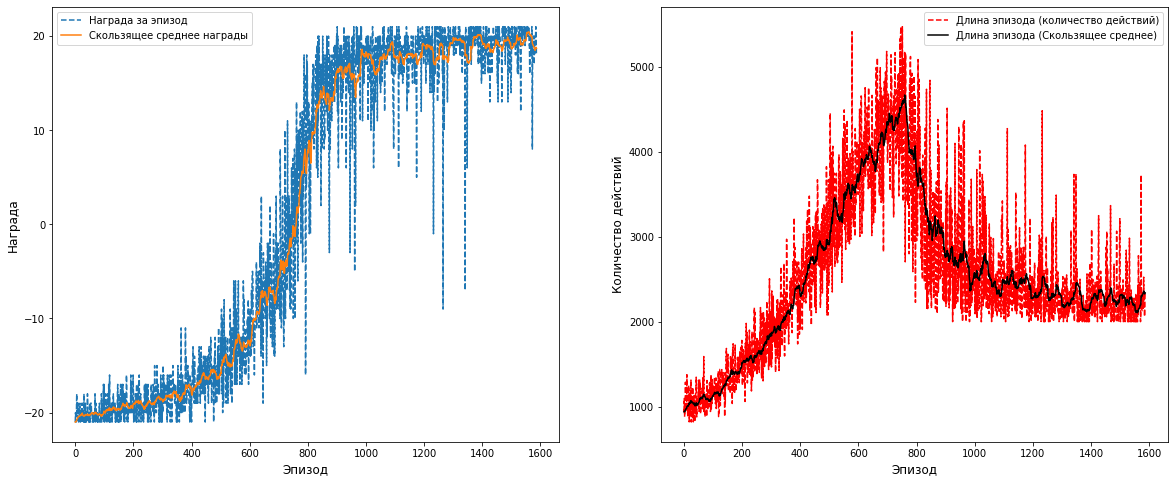

Закончен 1587-й эпизод, счёт: (агент) 21 - 3 (противник), продолжительность игры: 2352 кадров.


In [ ]:
env = gym.make('PongDeterministic-v4')     #Создаем среду Pong
while True:
  episode_states = []         #Создаем список где будут храниться все состояния одного эпизода (используется для обучения алгоритма)
  episode_actions = []        #Создаем список где будут храниться все действия за эпизод (используется для обучения алгоритма)
  episode_rewards = []        #Создаем список где будут храниться все награды за эпизод (используется для обучения алгоритма)

  new_frame = env.reset()          #Запускаем среду (это действие возвращает начальное состояние)
  old_frame = new_frame            #Инициализируем предидущий кадр как текущий кадр

  state = stack_frames(new_frame, old_frame) #Конкатенируем два кадра вместе чтобы создать состояние

  done = False               #Done - переменная говорит, если игровой эпизод завершён. Инициализируется с значением False.
  while not done:            #Пока игровой эпизод не завершён:
    action_index = choose_action(state)                                     #Выбираем новое действие по текущему состоянию среды
    new_frame, reward, done, misc = env.step(action_space[action_index])    #Подаем действие в среду, получаем новый кадр, награду, и узнаем если игра окончена.

    episode_states.append(state)                     #Добавляем состояние (с которым предсказывали действие) в массив состояний за эпизод.
    episode_actions.append(action_index)             #Добавляем действие в массив действий за эпизод.
    episode_rewards.append(reward)                   #Добавляем полученную награду в массив наград за эпизод.
    state = stack_frames(new_frame, old_frame)       #Создаем новое состояния, используя новый кадр (это нужно делать после добавление состояния в массив)

    old_frame = new_frame            #Устанавливаем старый кадр как новый кадр (таким образом запонимаем старый кадр)

  episode_number += 1                     #Увеличиваем счетчик (который отвечает за номер эпизода) на 1.
  episode_timesteps = len(episode_states) #Длина эпизода (количество кадров в эпизоде) равно количеству состояний за эпизод.

  episode_states, episode_actions, episode_rewards = np.array(episode_states), np.array(episode_actions), np.array(episode_rewards) #Переводим данные в numpy массивы
  points_won = episode_rewards[episode_rewards > 0].size   #Считаем количество положительных наград (равно количеству голов, который забил агент)
  points_lost = episode_rewards[episode_rewards < 0].size  #Считаем количество отрициательных наград (равно количеству голов, который пропустил агент)

  train(episode_states, episode_actions, episode_rewards) #Обучаем модель, используя состояния в эпизоде, соответствующие действия, и награды.

  episode_score = points_won - points_lost         #Очки за эпизод = количество забитых голов - количество пропущенных голов
  all_scores.append(episode_score)                 #Добавляем количество очков в список (используется в качестве метрики)
  all_episode_durations.append(episode_timesteps)  #Добавляем длину эпизода в список (используется в качестве метрики)

  show_scores(all_scores, all_episode_durations)   #Отображаем метрики на графике

  if episode_number % 10 == 0:    #Сохраняем прогресс раз в 10 эпизодов
    model.save_weights('/content/drive/My Drive/pretrained_networks/a2c_pong/actor_critic.h5')   #Сохраняем веса модели
    with open('/content/drive/My Drive/pretrained_networks/a2c_pong/scores.txt', 'wb') as f:  #Открываем файл используя функцию из pickle
      pickle.dump([all_scores, all_episode_durations, episode_number], f)    #Записываем метрики (очки за эпизоды, длины эпизодов, и номер эпизода) в файл

  #Дополнительно выводим статистику за эпизод через print.
  print(f"Закончен {episode_number}-й эпизод, счёт: (агент) {points_won} - {points_lost} (противник), продолжительность игры: {episode_timesteps} кадров.")

# Мы только что создали алгоритм "преймущественный актёр-критик"!

Как видите, здесь действительно не много отличий от базового занятия по градиентной политике. Разница в алгоритме не большая - по сути, мы всего лишь обучаем алгоритм не на наградах а на преймуществах, но для этого нам нужно создать вторую нейронную сеть, которая известна как **критик**.

По графику видно, что актёр-критик обучается дольше, чем базовый алгоритм градиентной политики. Это вполне ожидаемо, по скольку в данном алгоритме нам нужно чтобы обучился критик, и лишь потом может начаться обучение актёра. 

Однако, стоит отметить что само качество обучение на порядок выше, чем при базовом алгоритме! При обычной градиентной политике, агент выигрывал с средним счетом 21-6. Здесь он выигрывает с средним счетом 21-1. При этом, нужно отметить что Pong на самом деле является очент простой средой, и что разница будет намного более значемой в более сложных средах!

По сути, преймущественный актёр-критик - это прямое и очень значительное улучшение над базовым алгоритмом градиентной политики. Но актёр-критик всё же не является наилучшим алгоритмом в своем классе - есть ещё более способный алгоритм, который известен как **ближайшая оптимизация политики** (proximal policy optimization) - её мы изучим на следующим занятии!

##Тестируем работу агента

Дальше опять всё также, как было в предидущем занятии.

Сначала мы создаем функцию для принятия действий после обучения. Эта функция работает также, но она снова модифицируется чтобы учесть что модель возвращает два значения (вероятности действия и ценность состояния).

Ценность состояния по прежднему никак не используется.

In [ ]:
def choose_test_action(state):   #Создаем функцию для выбора действия при тесте
  value, probs = model.predict(state.reshape(1, 80, 80, 2))  #Делаем предикт модели
  action_index = np.argmax(probs.flatten())           #Вместо выбора действия рандомно, выбираем действие с максимальной вероятностью.
  return action_index   #Возвращаем индекс детерминированно выбранного действия (в игровом цикле мы будем обращаться к самому действию через этот индекс).

## Создаем видео с игрой агента

Чтобы создать видео, мы сначала создадим массив (список), куда будем поочередно добавлять кадры из игрового эпизода. Затем, с помощью библиотеки moviepy, мы превратим массив из кадров в видео.

In [ ]:
video_frames = []  #Кадры из игр будут записываться в этот массив
env = gym.make('PongDeterministic-v4')  #Создаем среду Pong
  
new_frame = env.reset()          #Запускаем среду (это действие возвращает начальное состояние)
old_frame = new_frame            #Инициализируем предидущий кадр как текущий кадр
state = stack_frames(new_frame, old_frame) #Конкатенируем два кадра вместе чтобы создать состояние

done = False               #Done - переменная говорит, если игровой эпизод завершён. Инициализируется с значением False.
while not done:            #Пока игровой эпизод не завершён:
  action_index = choose_test_action(state)                                  #Выбираем новое действие по текущему состоянию среды детерминированным образом
  new_frame, reward, done, misc = env.step(action_space[action_index])      #Подаем действие в среду, получаем новый кадр (награда уже не нужна)
  video_frames.append(new_frame)                     #Добавляем новый кадр в массив кадров

  state = stack_frames(new_frame, old_frame)         #Склеиваем новый и старый кадр вместе чтобы создать новое состояние для подачи в нейросеть.
  old_frame = new_frame         #Устанавливаем старый кадр как новый кадр (таким образом запонимаем старый кадр)

In [ ]:
#Создаем объект для воспроизведение видео (задаем путь к файлу видео, формат видео, кадры в секунду, и размер изображений)
out = cv2.VideoWriter('/content/episode.avi', cv2.VideoWriter_fourcc(*'DIVX'), 30, (160, 210)) #Чем больше кадров в секунду, тем быстее видео будет проигрываться
for i in range(len(video_frames)):   #В цикле добавляем каждый кадр в видео (делаем предобработку кадра - меняем каналы с RGB в BGR - это нужно потому что cv2 воспринимает каналы как BGR)
  out.write(cv2.cvtColor(video_frames[i], cv2.COLOR_RGB2BGR))
out.release()   #Закрываем объект для создания видео

In [ ]:
path="/content/episode.avi" #Указываем путь к видео

clip=VideoFileClip(path)    #Извлекаем видео из заданного пути (куда мы ранее записыли видео через cv2)
clip.ipython_display(width=320, maxduration = 100) #Отображаем видео в колабе